In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation

torch.multiprocessing.set_start_method('spawn')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from pyquaternion import Quaternion
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm

from src.preprocess import sample_to_rangeview, pcl_to_rangeview
from src.utils import rotation_matrix
from src.settings import DATASET_PATH, LABEL_NUMBER, RV_WIDTH, RV_HEIGHT, NUSCENES
from src.datasets import NuscenesRangeViewDataset
from src.models.lasernet import LaserNet
from src.losses import LaserNetLoss

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 23.230 seconds.
Reverse indexing ...
Done reverse indexing in 6.6 seconds.


---

## Training data 

- ___Classification___ task includes semantic segmentation. We predict class labels for each point (cell) in the Range View. If a cell in RV gets a class C, we extrapolate that all points (which fell into that cell during the transformation to RV) get the same label.
- ___Regression___ task includes BB regression and mixture parameter tuning

so a single training example consists of: 

- __$X$__: range_view image | __5 x W x H__


- __$Y_{image}$:__ | __C x W x H__, where C - number of classes


- __$Y_{bb}$:__ $\{\{b_{m,1}, b_{m,2}, b_{m,3}, b_{m,4}\}, ..., \}_m^M$ | __M x 4 x 2 x W x H__ | where M is the number of bounding boxes in the image, $b_{m, j} \in R ^2$ is the absolute coordinate of $m$-th bounding box's $j$-th corner

- __$Y_{logstd}$:__ $\log(\sigma)$ of the predicted bb coordinates| __scalar__
    

### DataSets, DataLoaders and Transforms

In [2]:
%%time
train_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 4))
val_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 4))

CPU times: user 339 µs, sys: 4.06 ms, total: 4.4 ms
Wall time: 3.15 ms


/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_features = np.array(self.point_clouds_features)
/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.point_clouds_labels = np.array(self.point_clouds_labels)


In [3]:
# %%time
# train_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 8064))
# val_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(8064, 9152))

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=0)

---

## Training the model

1. For each point in the image, we use the focal loss $L_{prob}$ to learn the class probabilities $\{p_c\}_{c=1}^C$. The classification loss for the entire image is defined as follows 
$$
L_{cls} = {1 \over P} \sum_i{L_{prob, i}}
$$ 
where P is the number of points in the image

2. For each point on an object, we learn the parameters of the object’s mixture model by first identifying which component best matches the ground truth
$$
k^* = \arg \min_k || \hat b_k − b^{gt} ||
$$
where $\hat b_k$ is the k-th mean component of the mixture model
and $b^{gt}$ is the corresponding ground truth bounding box.

3. Afterwards, we update the parameters of the $k^{*}$ component
$$
L_{box} = \sum_n {1 \over \hat \sigma_{k^*}} | \hat b_{n, k} − b^{gt}_n | + \log{\hat \sigma_{k^*}}
$$


4. Next, we update the mixture weights $\{α_k\}^K_{k=1}$ again using the multi-class cross entropy loss $L_{mix}$, where the positive label corresponds to the $k^*$ component

5. The regression loss for the entire image is defined as follows:
$$
L_{reg} = {{1 \over N} \sum_i{L_{box, i} + \lambda L_{mix, i} \over n_i}}
$$
where $L_{box, i}$ and $L_{mix, i}$ are the losses for the $i$-th point in the image which is on an object, $n_i$ is the total number of points that lie on the same object as $i$, $N$ is the total instances of objects in the image, and $\lambda$ is the relative weighting of the two losses.

6. Final loss is 

$$
L = L_{reg} + L_{cls}
$$

___!NOTE! In this experiment we do not model a distribution of BB, which is equivalent to having a single mixture component or  K=1. Meaning: we do not have $L_{mix}$, we skip step 2___

---

In [5]:
EPOCHS = 3000

lasernet = torch.nn.DataParallel(LaserNet(), device_ids=[0, 1])
loss = LaserNetLoss()
optimizer = torch.optim.Adam(lasernet.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)


lasernet.zero_grad()
loss.zero_grad()
optimizer.zero_grad()

train_losses = []
train_accs = []

val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    
    for batch_rv, batch_labels, batch_target_bbs in train_dataloader:
        
        batch_pointclass_preds, batch_bb_param_preds, batch_log_stds = lasernet(x=batch_rv)
        
#         print(batch_pointclass_preds.shape, batch_bb_param_preds.shape, batch_log_stds.shape)
        
        L_train = loss(batch_pointclass_preds, batch_bb_param_preds, batch_log_stds, 
                       batch_labels, batch_target_bbs)
        
        lasernet.zero_grad()
        L_train.backward()
        optimizer.step()
    
#     with torch.no_grad():
#         for batch_rv, batch_labels, batch_target_bbs in val_dataloader:
            
#             batch_pointclass_preds, batch_bb_param_preds = lasernet(x=batch_rv)

#             L_val = loss(batch_pointclass_preds, batch_bb_param_preds, batch_labels, batch_target_bbs)
        
#             val_losses.append(L_val.item())

#     torch.save(lasernet, f'lasernet-d{len(train_dataset)}-b64-e{epoch}-adam-lr002-sch095e1')


    if epoch % 10 == 0:
        batch_pointclass_pred_labels = torch.argmax(batch_pointclass_preds, axis=1)
        batch_pointclass_labels = torch.argmax(batch_labels, axis=1)
        
        correct_preds = torch.sum(batch_pointclass_pred_labels == batch_pointclass_labels)
        all_points = torch.sum(batch_pointclass_labels == batch_pointclass_labels)
        accuracy = (correct_preds / all_points).item() * 100
        
        train_losses.append(L_train.item())
        train_accs.append(accuracy)
        
        print(epoch, "train_loss", L_train.item(), "accuracy",  accuracy) #, "val_loss", L_val.item())
    if epoch % 500 == 0:
        lr_scheduler.step()

|point_classification_loss| 3.342587471008301 |bounding_box_loss| 27.826549530029297
0 train_loss 31.16913604736328 accuracy 2.679443359375
|point_classification_loss| 3.117117166519165 |bounding_box_loss| 6.565252304077148
|point_classification_loss| 2.8915369510650635 |bounding_box_loss| 6.381603240966797
|point_classification_loss| 2.823620319366455 |bounding_box_loss| 5.591870307922363
|point_classification_loss| 2.6858649253845215 |bounding_box_loss| 5.079899787902832
|point_classification_loss| 2.481187582015991 |bounding_box_loss| 4.456930160522461
|point_classification_loss| 2.379803419113159 |bounding_box_loss| 4.449979305267334
|point_classification_loss| 2.2198781967163086 |bounding_box_loss| 3.870194911956787
|point_classification_loss| 2.1734747886657715 |bounding_box_loss| 4.17371129989624
|point_classification_loss| 2.0690436363220215 |bounding_box_loss| 3.609534502029419
|point_classification_loss| 1.9723238945007324 |bounding_box_loss| 3.4018101692199707
10 train_loss 

|point_classification_loss| 0.8496577739715576 |bounding_box_loss| 2.2854905128479004
|point_classification_loss| 0.8485795259475708 |bounding_box_loss| 2.3487119674682617
|point_classification_loss| 0.878894567489624 |bounding_box_loss| 2.3098554611206055
|point_classification_loss| 0.8480392098426819 |bounding_box_loss| 2.3153328895568848
|point_classification_loss| 0.8152568340301514 |bounding_box_loss| 2.234943389892578
|point_classification_loss| 0.8240859508514404 |bounding_box_loss| 2.267225980758667
|point_classification_loss| 0.8367334604263306 |bounding_box_loss| 2.2883150577545166
|point_classification_loss| 0.7964861989021301 |bounding_box_loss| 2.250478506088257
|point_classification_loss| 0.8123059868812561 |bounding_box_loss| 2.2819037437438965
|point_classification_loss| 0.7818436622619629 |bounding_box_loss| 2.3556671142578125
100 train_loss 3.1375110149383545 accuracy 57.452392578125
|point_classification_loss| 0.8140153884887695 |bounding_box_loss| 2.262237071990967


|point_classification_loss| 0.5673836469650269 |bounding_box_loss| 2.196161985397339
|point_classification_loss| 0.5274088978767395 |bounding_box_loss| 2.162269115447998
|point_classification_loss| 0.528725266456604 |bounding_box_loss| 2.1417417526245117
|point_classification_loss| 0.5431133508682251 |bounding_box_loss| 2.1597378253936768
|point_classification_loss| 0.582895040512085 |bounding_box_loss| 2.197671890258789
|point_classification_loss| 0.5245457887649536 |bounding_box_loss| 2.123353958129883
|point_classification_loss| 0.5424619317054749 |bounding_box_loss| 2.103682041168213
|point_classification_loss| 0.5277677178382874 |bounding_box_loss| 2.19476318359375
|point_classification_loss| 0.4833008646965027 |bounding_box_loss| 2.164501190185547
|point_classification_loss| 0.5166656970977783 |bounding_box_loss| 2.1697285175323486
190 train_loss 2.686394214630127 accuracy 71.075439453125
|point_classification_loss| 0.5388324856758118 |bounding_box_loss| 2.16347074508667
|point_c

|point_classification_loss| 0.37050777673721313 |bounding_box_loss| 2.056952953338623
|point_classification_loss| 0.36513710021972656 |bounding_box_loss| 2.109067916870117
|point_classification_loss| 0.3649928569793701 |bounding_box_loss| 2.0247747898101807
|point_classification_loss| 0.36648765206336975 |bounding_box_loss| 2.0337653160095215
|point_classification_loss| 0.33843177556991577 |bounding_box_loss| 1.9902821779251099
|point_classification_loss| 0.35570332407951355 |bounding_box_loss| 1.9977245330810547
|point_classification_loss| 0.34790581464767456 |bounding_box_loss| 2.04557466506958
|point_classification_loss| 0.3569967746734619 |bounding_box_loss| 2.0238242149353027
|point_classification_loss| 0.3796646296977997 |bounding_box_loss| 2.0799851417541504
|point_classification_loss| 0.37701261043548584 |bounding_box_loss| 2.065222978591919
280 train_loss 2.4422354698181152 accuracy 77.33154296875
|point_classification_loss| 0.36823537945747375 |bounding_box_loss| 2.0513978004

|point_classification_loss| 0.2853398323059082 |bounding_box_loss| 2.015493631362915
|point_classification_loss| 0.2864319384098053 |bounding_box_loss| 2.0717544555664062
|point_classification_loss| 0.2952251136302948 |bounding_box_loss| 1.926177740097046
|point_classification_loss| 0.29031112790107727 |bounding_box_loss| 1.9154585599899292
|point_classification_loss| 0.3143940269947052 |bounding_box_loss| 2.0449061393737793
|point_classification_loss| 0.2880701422691345 |bounding_box_loss| 1.9634422063827515
|point_classification_loss| 0.2803630828857422 |bounding_box_loss| 1.9840726852416992
|point_classification_loss| 0.3052462935447693 |bounding_box_loss| 1.9801291227340698
|point_classification_loss| 0.3158198893070221 |bounding_box_loss| 2.077662467956543
|point_classification_loss| 0.30674856901168823 |bounding_box_loss| 1.93976628780365
370 train_loss 2.2465150356292725 accuracy 79.437255859375
|point_classification_loss| 0.2714862823486328 |bounding_box_loss| 1.929411888122558

|point_classification_loss| 0.24695095419883728 |bounding_box_loss| 1.9304566383361816
|point_classification_loss| 0.2668796479701996 |bounding_box_loss| 1.8608577251434326
|point_classification_loss| 0.26259487867355347 |bounding_box_loss| 1.9171613454818726
|point_classification_loss| 0.25603848695755005 |bounding_box_loss| 1.8659961223602295
|point_classification_loss| 0.25006335973739624 |bounding_box_loss| 1.9443731307983398
|point_classification_loss| 0.25244462490081787 |bounding_box_loss| 1.8752868175506592
|point_classification_loss| 0.2574869990348816 |bounding_box_loss| 1.981218695640564
|point_classification_loss| 0.3049356937408447 |bounding_box_loss| 1.8988568782806396
|point_classification_loss| 0.24546483159065247 |bounding_box_loss| 1.9835195541381836
|point_classification_loss| 0.2702213525772095 |bounding_box_loss| 1.941345453262329
460 train_loss 2.211566686630249 accuracy 81.353759765625
|point_classification_loss| 0.2871907353401184 |bounding_box_loss| 1.937805175

|point_classification_loss| 0.2288668304681778 |bounding_box_loss| 1.877448558807373
|point_classification_loss| 0.2016317993402481 |bounding_box_loss| 1.8263137340545654
|point_classification_loss| 0.2167920172214508 |bounding_box_loss| 1.8043092489242554
|point_classification_loss| 0.22685953974723816 |bounding_box_loss| 1.8727115392684937
|point_classification_loss| 0.2213362157344818 |bounding_box_loss| 1.844736099243164
|point_classification_loss| 0.2428821474313736 |bounding_box_loss| 1.8311885595321655
|point_classification_loss| 0.2059561312198639 |bounding_box_loss| 1.8843727111816406
|point_classification_loss| 0.2085077315568924 |bounding_box_loss| 1.8496967554092407
|point_classification_loss| 0.20591261982917786 |bounding_box_loss| 1.8067717552185059
|point_classification_loss| 0.22948835790157318 |bounding_box_loss| 1.8576314449310303
550 train_loss 2.0871198177337646 accuracy 83.758544921875
|point_classification_loss| 0.20764921605587006 |bounding_box_loss| 1.8417289257

|point_classification_loss| 0.19378340244293213 |bounding_box_loss| 1.7968698740005493
|point_classification_loss| 0.2230992168188095 |bounding_box_loss| 1.815183401107788
|point_classification_loss| 0.1991627812385559 |bounding_box_loss| 1.8194026947021484
|point_classification_loss| 0.19603630900382996 |bounding_box_loss| 1.7982921600341797
|point_classification_loss| 0.19386902451515198 |bounding_box_loss| 1.7848544120788574
|point_classification_loss| 0.19829168915748596 |bounding_box_loss| 1.8112163543701172
|point_classification_loss| 0.1909371018409729 |bounding_box_loss| 1.8315348625183105
|point_classification_loss| 0.18657958507537842 |bounding_box_loss| 1.798187017440796
|point_classification_loss| 0.2073621153831482 |bounding_box_loss| 1.8084559440612793
|point_classification_loss| 0.20530003309249878 |bounding_box_loss| 1.8356239795684814
640 train_loss 2.040924072265625 accuracy 85.296630859375
|point_classification_loss| 0.194740429520607 |bounding_box_loss| 1.7805234193

|point_classification_loss| 0.17531022429466248 |bounding_box_loss| 1.7601912021636963
|point_classification_loss| 0.16558079421520233 |bounding_box_loss| 1.724459171295166
|point_classification_loss| 0.1700870394706726 |bounding_box_loss| 1.7298308610916138
|point_classification_loss| 0.16354431211948395 |bounding_box_loss| 1.7706526517868042
|point_classification_loss| 0.16493667662143707 |bounding_box_loss| 1.7515194416046143
|point_classification_loss| 0.19160863757133484 |bounding_box_loss| 1.7761003971099854
|point_classification_loss| 0.18988296389579773 |bounding_box_loss| 1.7769014835357666
|point_classification_loss| 0.18508663773536682 |bounding_box_loss| 1.7240262031555176
|point_classification_loss| 0.17639993131160736 |bounding_box_loss| 1.7283267974853516
|point_classification_loss| 0.18976879119873047 |bounding_box_loss| 1.754895567893982
730 train_loss 1.944664478302002 accuracy 86.51123046875
|point_classification_loss| 0.18178395926952362 |bounding_box_loss| 1.779922

|point_classification_loss| 0.1716967523097992 |bounding_box_loss| 1.7231144905090332
|point_classification_loss| 0.1711464822292328 |bounding_box_loss| 1.7045537233352661
|point_classification_loss| 0.1695137768983841 |bounding_box_loss| 1.7643697261810303
|point_classification_loss| 0.15349224209785461 |bounding_box_loss| 1.6702930927276611
|point_classification_loss| 0.1663355678319931 |bounding_box_loss| 1.7460155487060547
|point_classification_loss| 0.16928939521312714 |bounding_box_loss| 1.6811277866363525
|point_classification_loss| 0.1536332070827484 |bounding_box_loss| 1.677382469177246
|point_classification_loss| 0.1768520474433899 |bounding_box_loss| 1.711751937866211
|point_classification_loss| 0.17019203305244446 |bounding_box_loss| 1.7083404064178467
|point_classification_loss| 0.17086713016033173 |bounding_box_loss| 1.7558391094207764
820 train_loss 1.9267061948776245 accuracy 87.109375
|point_classification_loss| 0.15760764479637146 |bounding_box_loss| 1.685574293136596

|point_classification_loss| 0.15762104094028473 |bounding_box_loss| 1.7021161317825317
|point_classification_loss| 0.1670987606048584 |bounding_box_loss| 1.6641932725906372
|point_classification_loss| 0.1467435210943222 |bounding_box_loss| 1.6375807523727417
|point_classification_loss| 0.14309433102607727 |bounding_box_loss| 1.7228455543518066
|point_classification_loss| 0.15396833419799805 |bounding_box_loss| 1.6191484928131104
|point_classification_loss| 0.1412017047405243 |bounding_box_loss| 1.655017614364624
|point_classification_loss| 0.13529427349567413 |bounding_box_loss| 1.6629924774169922
|point_classification_loss| 0.14340579509735107 |bounding_box_loss| 1.638060450553894
|point_classification_loss| 0.13750681281089783 |bounding_box_loss| 1.6633813381195068
|point_classification_loss| 0.1551501750946045 |bounding_box_loss| 1.7070398330688477
910 train_loss 1.8621900081634521 accuracy 87.82958984375
|point_classification_loss| 0.12452028691768646 |bounding_box_loss| 1.62654399

|point_classification_loss| 0.15178795158863068 |bounding_box_loss| 1.5639920234680176
|point_classification_loss| 0.1422901749610901 |bounding_box_loss| 1.5776522159576416
|point_classification_loss| 0.1617252677679062 |bounding_box_loss| 1.6082514524459839
|point_classification_loss| 0.12081994116306305 |bounding_box_loss| 1.658943772315979
|point_classification_loss| 0.12631213665008545 |bounding_box_loss| 1.6814460754394531
|point_classification_loss| 0.14381667971611023 |bounding_box_loss| 1.637312889099121
|point_classification_loss| 0.14560911059379578 |bounding_box_loss| 1.6288505792617798
|point_classification_loss| 0.19465425610542297 |bounding_box_loss| 1.6499426364898682
|point_classification_loss| 0.16508929431438446 |bounding_box_loss| 1.647600769996643
|point_classification_loss| 0.14634691178798676 |bounding_box_loss| 1.5571177005767822
1000 train_loss 1.7034645080566406 accuracy 88.525390625
|point_classification_loss| 0.13966351747512817 |bounding_box_loss| 1.58249402

|point_classification_loss| 0.15925940871238708 |bounding_box_loss| 1.570923924446106
|point_classification_loss| 0.1356511414051056 |bounding_box_loss| 1.5517776012420654
|point_classification_loss| 0.1320914924144745 |bounding_box_loss| 1.5764775276184082
|point_classification_loss| 0.1369437724351883 |bounding_box_loss| 1.591126561164856
|point_classification_loss| 0.13413885235786438 |bounding_box_loss| 1.5866773128509521
|point_classification_loss| 0.12688034772872925 |bounding_box_loss| 1.5794059038162231
|point_classification_loss| 0.14296890795230865 |bounding_box_loss| 1.5488417148590088
|point_classification_loss| 0.12850557267665863 |bounding_box_loss| 1.549210548400879
|point_classification_loss| 0.12393589317798615 |bounding_box_loss| 1.6139589548110962
|point_classification_loss| 0.13175705075263977 |bounding_box_loss| 1.600931167602539
1090 train_loss 1.7326881885528564 accuracy 89.46533203125
|point_classification_loss| 0.11269629001617432 |bounding_box_loss| 1.53625833

|point_classification_loss| 0.12345992773771286 |bounding_box_loss| 1.5257350206375122
|point_classification_loss| 0.14601102471351624 |bounding_box_loss| 1.5380955934524536
|point_classification_loss| 0.11396320164203644 |bounding_box_loss| 1.5238382816314697
|point_classification_loss| 0.10830464959144592 |bounding_box_loss| 1.5169055461883545
|point_classification_loss| 0.118098683655262 |bounding_box_loss| 1.5021967887878418
|point_classification_loss| 0.12206017971038818 |bounding_box_loss| 1.4701313972473145
|point_classification_loss| 0.12074045091867447 |bounding_box_loss| 1.4920849800109863
|point_classification_loss| 0.1327182650566101 |bounding_box_loss| 1.51627516746521
|point_classification_loss| 0.10767435282468796 |bounding_box_loss| 1.4712860584259033
|point_classification_loss| 0.12300924211740494 |bounding_box_loss| 1.5478742122650146
1180 train_loss 1.6708834171295166 accuracy 89.874267578125
|point_classification_loss| 0.10854567587375641 |bounding_box_loss| 1.54777

|point_classification_loss| 0.11897897720336914 |bounding_box_loss| 1.4774433374404907
|point_classification_loss| 0.11867336928844452 |bounding_box_loss| 1.5108122825622559
|point_classification_loss| 0.11301815509796143 |bounding_box_loss| 1.5329415798187256
|point_classification_loss| 0.13114593923091888 |bounding_box_loss| 1.5045289993286133
|point_classification_loss| 0.13161246478557587 |bounding_box_loss| 1.537843108177185
|point_classification_loss| 0.1200326532125473 |bounding_box_loss| 1.505568265914917
|point_classification_loss| 0.11616845428943634 |bounding_box_loss| 1.4973790645599365
|point_classification_loss| 0.12413506954908371 |bounding_box_loss| 1.5100815296173096
|point_classification_loss| 0.1418309211730957 |bounding_box_loss| 1.5182199478149414
|point_classification_loss| 0.10909219086170197 |bounding_box_loss| 1.4948043823242188
1270 train_loss 1.6038963794708252 accuracy 90.71044921875
|point_classification_loss| 0.1206798106431961 |bounding_box_loss| 1.492990

|point_classification_loss| 0.11031559109687805 |bounding_box_loss| 1.5370945930480957
|point_classification_loss| 0.11591638624668121 |bounding_box_loss| 1.5077704191207886
|point_classification_loss| 0.12638890743255615 |bounding_box_loss| 1.4723880290985107
|point_classification_loss| 0.11584828048944473 |bounding_box_loss| 1.4827238321304321
|point_classification_loss| 0.10952111333608627 |bounding_box_loss| 1.4469321966171265
|point_classification_loss| 0.11250682175159454 |bounding_box_loss| 1.444706678390503
|point_classification_loss| 0.09924092888832092 |bounding_box_loss| 1.527246117591858
|point_classification_loss| 0.11493711173534393 |bounding_box_loss| 1.4525353908538818
|point_classification_loss| 0.11713650822639465 |bounding_box_loss| 1.4476609230041504
|point_classification_loss| 0.10920573770999908 |bounding_box_loss| 1.441738486289978
1360 train_loss 1.550944209098816 accuracy 90.740966796875
|point_classification_loss| 0.10940603166818619 |bounding_box_loss| 1.4896

|point_classification_loss| 0.1098671704530716 |bounding_box_loss| 1.4734554290771484
|point_classification_loss| 0.10586249828338623 |bounding_box_loss| 1.4861974716186523
|point_classification_loss| 0.1125175878405571 |bounding_box_loss| 1.4962728023529053
|point_classification_loss| 0.12482979148626328 |bounding_box_loss| 1.4644527435302734
|point_classification_loss| 0.11373298615217209 |bounding_box_loss| 1.4474587440490723
|point_classification_loss| 0.10936006903648376 |bounding_box_loss| 1.52744460105896
|point_classification_loss| 0.10326583683490753 |bounding_box_loss| 1.4737555980682373
|point_classification_loss| 0.09883122891187668 |bounding_box_loss| 1.4731695652008057
|point_classification_loss| 0.10119583457708359 |bounding_box_loss| 1.473860502243042
|point_classification_loss| 0.09994257986545563 |bounding_box_loss| 1.4317500591278076
1450 train_loss 1.531692624092102 accuracy 91.4794921875
|point_classification_loss| 0.1009230986237526 |bounding_box_loss| 1.455917835

|point_classification_loss| 0.07997357845306396 |bounding_box_loss| 1.4015586376190186
|point_classification_loss| 0.10255484282970428 |bounding_box_loss| 1.3994874954223633
|point_classification_loss| 0.10606198012828827 |bounding_box_loss| 1.4150192737579346
|point_classification_loss| 0.0909971296787262 |bounding_box_loss| 1.38341224193573
|point_classification_loss| 0.10008000582456589 |bounding_box_loss| 1.4417951107025146
|point_classification_loss| 0.0892724022269249 |bounding_box_loss| 1.4511938095092773
|point_classification_loss| 0.10817918181419373 |bounding_box_loss| 1.4483553171157837
|point_classification_loss| 0.09092655777931213 |bounding_box_loss| 1.4601587057113647
|point_classification_loss| 0.1035875603556633 |bounding_box_loss| 1.4747053384780884
|point_classification_loss| 0.09282591193914413 |bounding_box_loss| 1.4218354225158691
1540 train_loss 1.514661192893982 accuracy 92.2119140625
|point_classification_loss| 0.08623339980840683 |bounding_box_loss| 1.45904493

|point_classification_loss| 0.10104639828205109 |bounding_box_loss| 1.460688591003418
|point_classification_loss| 0.09330000728368759 |bounding_box_loss| 1.422431230545044
|point_classification_loss| 0.08203019201755524 |bounding_box_loss| 1.399867296218872
|point_classification_loss| 0.0957627147436142 |bounding_box_loss| 1.432420253753662
|point_classification_loss| 0.09308755397796631 |bounding_box_loss| 1.4388446807861328
|point_classification_loss| 0.10316583514213562 |bounding_box_loss| 1.4073238372802734
|point_classification_loss| 0.11945468932390213 |bounding_box_loss| 1.4871294498443604
|point_classification_loss| 0.10973171889781952 |bounding_box_loss| 1.4611177444458008
|point_classification_loss| 0.10355305671691895 |bounding_box_loss| 1.4496545791625977
|point_classification_loss| 0.10300940275192261 |bounding_box_loss| 1.4771230220794678
1630 train_loss 1.5801324844360352 accuracy 91.46728515625
|point_classification_loss| 0.10560239851474762 |bounding_box_loss| 1.400788

|point_classification_loss| 0.09171313792467117 |bounding_box_loss| 1.393442988395691
|point_classification_loss| 0.09409624338150024 |bounding_box_loss| 1.3921616077423096
|point_classification_loss| 0.08037732541561127 |bounding_box_loss| 1.4067621231079102
|point_classification_loss| 0.09289446473121643 |bounding_box_loss| 1.341515302658081
|point_classification_loss| 0.0886315330862999 |bounding_box_loss| 1.386496663093567
|point_classification_loss| 0.09923198074102402 |bounding_box_loss| 1.3522027730941772
|point_classification_loss| 0.09134180843830109 |bounding_box_loss| 1.3701162338256836
|point_classification_loss| 0.08728113770484924 |bounding_box_loss| 1.4211026430130005
|point_classification_loss| 0.0926043689250946 |bounding_box_loss| 1.4019651412963867
|point_classification_loss| 0.08599457144737244 |bounding_box_loss| 1.492120385169983
1720 train_loss 1.5781149864196777 accuracy 92.181396484375
|point_classification_loss| 0.08551837503910065 |bounding_box_loss| 1.392299

|point_classification_loss| 0.08401160687208176 |bounding_box_loss| 1.3936822414398193
|point_classification_loss| 0.08843666315078735 |bounding_box_loss| 1.3695310354232788
|point_classification_loss| 0.09647640585899353 |bounding_box_loss| 1.3750450611114502
|point_classification_loss| 0.09220359474420547 |bounding_box_loss| 1.408522605895996
|point_classification_loss| 0.08694241940975189 |bounding_box_loss| 1.3632100820541382
|point_classification_loss| 0.08644992113113403 |bounding_box_loss| 1.4576795101165771
|point_classification_loss| 0.09667588770389557 |bounding_box_loss| 1.3667405843734741
|point_classification_loss| 0.08749841898679733 |bounding_box_loss| 1.3370635509490967
|point_classification_loss| 0.09757982939481735 |bounding_box_loss| 1.4058780670166016
|point_classification_loss| 0.08104608207941055 |bounding_box_loss| 1.374894618988037
1810 train_loss 1.4559407234191895 accuracy 93.060302734375
|point_classification_loss| 0.09967716038227081 |bounding_box_loss| 1.43

|point_classification_loss| 0.08665093034505844 |bounding_box_loss| 1.3609646558761597
|point_classification_loss| 0.07793841511011124 |bounding_box_loss| 1.398332953453064
|point_classification_loss| 0.07644648849964142 |bounding_box_loss| 1.3975389003753662
|point_classification_loss| 0.08533703535795212 |bounding_box_loss| 1.3291645050048828
|point_classification_loss| 0.08722500503063202 |bounding_box_loss| 1.3761248588562012
|point_classification_loss| 0.08604736626148224 |bounding_box_loss| 1.3784019947052002
|point_classification_loss| 0.08619087934494019 |bounding_box_loss| 1.3765610456466675
|point_classification_loss| 0.0833890438079834 |bounding_box_loss| 1.407991647720337
|point_classification_loss| 0.08717389404773712 |bounding_box_loss| 1.4031254053115845
|point_classification_loss| 0.09342257678508759 |bounding_box_loss| 1.3548389673233032
1900 train_loss 1.4482614994049072 accuracy 92.041015625
|point_classification_loss| 0.08908011019229889 |bounding_box_loss| 1.374868

|point_classification_loss| 0.08796902745962143 |bounding_box_loss| 1.421187400817871
|point_classification_loss| 0.09497220814228058 |bounding_box_loss| 1.3749724626541138
|point_classification_loss| 0.08145162463188171 |bounding_box_loss| 1.3581281900405884
|point_classification_loss| 0.09262187033891678 |bounding_box_loss| 1.3239537477493286
|point_classification_loss| 0.08539004623889923 |bounding_box_loss| 1.3646645545959473
|point_classification_loss| 0.07489307224750519 |bounding_box_loss| 1.3705666065216064
|point_classification_loss| 0.07502254843711853 |bounding_box_loss| 1.4432718753814697
|point_classification_loss| 0.0791914239525795 |bounding_box_loss| 1.3397948741912842
|point_classification_loss| 0.08869153261184692 |bounding_box_loss| 1.3328323364257812
|point_classification_loss| 0.08178392797708511 |bounding_box_loss| 1.3698492050170898
1990 train_loss 1.4516332149505615 accuracy 93.096923828125
|point_classification_loss| 0.07854614406824112 |bounding_box_loss| 1.36

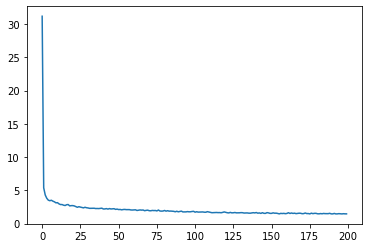

In [6]:
plt.plot(train_losses)
plt.show()

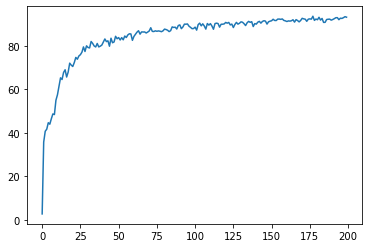

In [7]:
plt.plot(train_accs)
plt.show()

 |point_classification_loss| 3.1142218112945557 |bounding_box_loss| 33.404544830322266


110 train_loss 36.490665435791016 val_loss 36.518768310546875

---

|point_classification_loss| 2.604236602783203 |bounding_box_loss| 33.48299026489258


150 train_loss 36.030982971191406 val_loss 36.08722686767578


---

|point_classification_loss| 2.7289068698883057 |bounding_box_loss| 33.06686782836914


1710 train_loss 35.79496383666992 val_loss 35.7957763671875

---
__[3] after transform fix | cross entropy and MSE | no log std | lr=0.001| gamma 097 every 100 epochs__

|point_classification_loss| 0.25498661398887634 |bounding_box_loss| 85.12548828125

1980 train_loss 85.60669708251953 val_loss 85.47611236572266


bad boxes (even lines, not boxes) in the right places!

---
__[4] after transform fix | cross entropy and MSE | no log std | only non-zero boxes | lr=0.001| gamma 097 every 100 epochs____

|point_classification_loss| 0.8824732303619385 |bounding_box_loss| 19.866052627563477

870 train_loss 20.781124114990234 val_loss 20.748525619506836


looks more like boxes, but in the wrong places as well, may fals positives near ego

the further the object is, the thinner is it's bounding box

__[5] after transform fix | cross entropy and MSE | no log std | only non-zero boxes | lr=0.01| gamma 097 every 500 epochs__

|point_classification_loss| 0.3059435784816742 |bounding_box_loss| 20.469608306884766

870 train_loss 20.82895851135254 accuracy 89.617919921875


__[6] after transform fix| heads no elu | focal loss and log_std error | all boxes | lr=0.00005| gamma 095 every 200 epochs| std for each rv cell| mean by object__

too slow, could ve made the lr bigger or the decrease slower

|point_classification_loss| 0.2606876790523529 |bounding_box_loss| 1.9241503477096558


1990 train_loss 2.184837818145752 accuracy 83.06884765625

__[7] after transform fix| heads no elu | focal loss and log_std error | all boxes | lr=0.001| gamma 095 every 500 epochs| std for each rv cell| mean by object__

|point_classification_loss| 0.08178392797708511 |bounding_box_loss| 1.3698492050170898

1990 train_loss 1.4516332149505615 accuracy 93.096923828125


---

In [12]:
torch.save(lasernet, 'lasernet8')

In [13]:
non_object_labels = [0, 24, 25, 26, 27, 28, 29, 30, 31]

pointclass_preds, bb_param_preds, _ = lasernet(x=batch_rv)

pointclass_preds = pointclass_preds.detach().cpu().numpy()
bb_corner_preds = bb_param_preds.detach().cpu().numpy()


range_view_ex = batch_rv[0]
class_predictions_ex = pointclass_preds[0]
bb_corner_preds_ex = bb_corner_preds[0]

range_view_ex.shape, class_predictions_ex.shape, bb_corner_preds_ex.shape

(torch.Size([7, 128, 32]), (32, 128, 32), (8, 128, 32))

In [16]:
class_pred_labels_ex = np.argmax(class_predictions_ex, axis=0)
w, h = np.nonzero((sum([class_pred_labels_ex == nol for nol in non_object_labels]) == 0))

w_u, h_u = np.unique(w), np.unique(h)

# bb_corner_preds_ex = bb_corner_preds_ex.T.reshape(8, 128, 32)

bb_class_probs_ex = torch.softmax(torch.Tensor(class_predictions_ex), dim=0).cpu().numpy()

fig = go.Figure(data=[go.Scatter3d(x=range_view_ex[0].cpu().flatten(),
                                   y=range_view_ex[1].cpu().flatten(),
                                   z=np.zeros_like(range_view_ex[2].cpu().flatten()),
                                   mode='markers',
                                   marker=dict(size=2))])

for h_i in h_u:
    for w_i in w_u:
        # check model's certainty
        max_label = class_pred_labels_ex[w_i, h_i]
        class_prob = bb_class_probs_ex[max_label, w_i, h_i]
        if class_prob > 0.8:

            x = bb_corner_preds_ex[::2, w_i, h_i]
            y = bb_corner_preds_ex[1::2, w_i, h_i]
            fig.add_mesh3d(x=list(x), 
                           y=list(y),
                           z=np.zeros_like(x))

fig.write_html("kek8.html")

---

### Adding image information to the LaserNet

In [11]:
class LaserNetPP(nn.Module):
    pass

### Non-maximum supression

- first we discard all boxes with it's class probability less than 0.6
- then we select the most confident point and get rid of all boxes, that overlap with IoU >= 0.5